In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date
import scipy.optimize as optimize

In [2]:
class BootstrapYieldCurve():
    def __init__(self):
        self.zero_rates = dict() # Map each T to a zero rate 
        self.instruments = dict() 
    
    def add_instrument(self, face, T, coupon, price, compound_freq=2):
        self.instruments[T] = (face, coupon, price, compound_freq)
        
    def get_zero_rates(self):
        # Calculate zero rates
        self.__bootstrap_zero_coupons__() 
        self.__get_bond_spot_rates__()
        return [self.zero_rates[T] for T in self.get_maturities()]

    def get_maturities(self):
        # Return sorted maturities from each bond
        return sorted(self.instruments.keys())
   
    def __bootstrap_zero_coupons__(self):
        """ Get zero rates from zero coupon bonds """ 
        for T in self.instruments.keys():
            (face, coupon, price, freq) = self.instruments[T]
            if coupon == 0:
                self.zero_rates[T] = self.zero_coupon_spot_rate(face, price, T)
                
    def __get_bond_spot_rates__(self):
        """ Get spot rates for every marurity available """ 
        for T in self.get_maturities():
            instrument = self.instruments[T]
            (face, coupon, price, freq) = instrument
            if coupon != 0: 
                self.zero_rates[T] = self.__calculate_bond_spot_rate__( T, instrument)
                    
                    
    def __calculate_bond_spot_rate__(self, T, instrument): 
        """ Get spot rate of a bond by bootstrapping """ 
        try:
            (face, coupon, price, freq) = instrument
            periods = T * freq # Number of coupon payments 
            value = price
            per_coupon = coupon / freq # Coupon per period
            for i in range(int(periods) - 1): 
                #Calculate the spot rates and discount rates
                
                t = (i+1)/2               
                
                spot_rate = self.zero_rates[t]
                discounted_coupon = per_coupon *  math.exp(-spot_rate*t) 
                value -= discounted_coupon
            # Derive spot rate for a particular maturity 
            last_period = int(periods)/2 
            
            spot_rate = -math.log(value /(face+per_coupon))/last_period
            return spot_rate
        except:
            print("Error: spot rate not found for T=%s") #% t
            
            
    def zero_coupon_spot_rate(self, face, price, T):
        """ Get zero rate of a zero coupon bond """ 
        spot_rate = math.log(face/price)/T
        return spot_rate 

                
            



In [3]:
yield_curve = BootstrapYieldCurve()

In [4]:
yield_curve.add_instrument(100, 0.25, 0., 97.5)
yield_curve.add_instrument(100, 0.5, 0., 94.9)
yield_curve.add_instrument(100, 1.0, 0., 90.)
yield_curve.add_instrument(100, 1.5, 8, 96., 2)
yield_curve.add_instrument(100, 2., 12, 101.6, 2) 
y = yield_curve.get_zero_rates()
x = yield_curve.get_maturities()

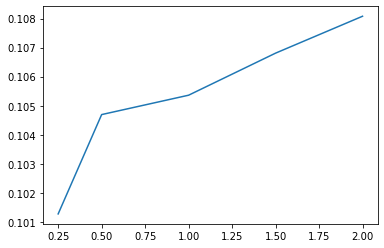

In [5]:
plt.plot(x,y)

In [6]:
bond_data = pd.read_csv("bond_data1.csv")
bond_data = pd.DataFrame(bond_data, columns=['ISIN', 'Coupon', 'Issue Date', 'Maturity Date',
                                            '2/1/2021', '1/29/2021', '1/28/2021', 
                                             '1/27/2021', '1/26/2021', '1/25/2021',
                                            '1/22/2021', '1/21/2021', '1/20/2021',
                                            '1/19/2021', '1/18/2021'])

In [7]:
#Clean up the data

bond_data['Maturity Date'] = bond_data["Maturity Date"].apply(pd.to_datetime, errors='ignore') 
bond_data['Issue Date'] = bond_data["Issue Date"].apply(pd.to_datetime, errors='ignore')
bond_data['Coupon'] = bond_data['Coupon'].str.strip('\%')
bond_data['ISIN'] = bond_data['ISIN'].str.strip('\n')
bond_data

,ISIN,Coupon,Issue Date,Maturity Date,2/1/2021,1/29/2021,1/28/2021,1/27/2021,1/26/2021,1/25/2021,1/22/2021,1/21/2021,1/20/2021,1/19/2021,1/18/2021
0,CA135087A610,1.5,2012-07-30,2023-06-01,103.085,103.075,103.095,103.095,103.065,103.060,103.090,103.085,103.100,103.140,103.150
1,CA135087F254,0.75,2015-10-19,2021-03-01,100.053,100.054,100.056,100.062,100.062,100.064,100.067,100.068,100.074,100.078,100.082
2,CA135087F585,0.75,2016-04-11,2021-09-01,100.053,100.054,100.056,100.062,100.062,100.064,100.067,100.068,100.074,100.078,100.082
3,CA135087G328,0.5,2016-10-11,2022-03-01,100.417,100.408,100.405,100.406,100.396,100.392,100.407,100.404,100.409,100.432,100.447
4,CA135087H490,1.75,2017-10-06,2023-03-01,103.255,103.245,103.245,103.250,103.225,103.215,103.245,103.235,103.250,103.280,103.290
5,CA135087J629,2.25,2018-11-09,2021-02-01,100.010,100.010,100.010,100.010,100.020,100.020,100.030,100.030,100.050,100.060,100.060
6,CA135087J884,1.75,2019-02-11,2021-05-01,100.409,100.412,100.416,100.429,100.431,100.434,100.442,100.446,100.460,100.470,100.478
7,CA135087K296,1.5,2019-05-06,2021-08-01,100.697,100.696,100.699,100.709,100.706,100.708,100.719,100.721,100.732,100.748,100.757
8,CA135087K452,1.25,2019-08-09,2021-11-01,100.850,100.846,100.848,100.857,100.849,100.849,100.863,100.864,100.874,100.894,100.904
9,CA135087K601,1.5,2019-11-04,2022-02-01,101.382,101.377,101.377,101.388,101.378,101.377,101.393,101.392,101.404,101.431,101.443


In [8]:
#Calculate time to maturity

ytm=[]
for element in bond_data["Maturity Date"]:
    
    ttm = (element -  pd.Timestamp(2021,2,1) )     
    ytm.append(ttm)

pdf = pd.DataFrame(ytm)

#Add it to our data table
    
bond_data['TTM'] = pdf
bond_data['TTM'].astype(str).str.strip('days')
bond_data['TTM'] = bond_data['TTM'].astype('timedelta64[D]').div(360)

#Now lets calculate the yeld to maturity YTM for each bond
# Note choose period to be 10 since by annual payement

coupons = bond_data['Coupon'].astype(float)
ttm = bond_data["TTM"]
price1 = bond_data['1/18/2021']
price2 = bond_data['1/19/2021']
price3 = bond_data['1/20/2021']
price4 = bond_data['1/21/2021']
price5 = bond_data['1/22/2021']
price6 = bond_data['1/25/2021']
price7 = bond_data['1/26/2021']
price8 = bond_data['1/27/2021']
price9 = bond_data['1/28/2021']
price10 = bond_data['1/29/2021']
price11 = bond_data['2/1/2021']
maturity1 = bond_data['Maturity Date']


filtered_data = bond_data.mask((ttm < 2) ).dropna()
filtered_data.sort_values(by='Coupon')
filtered_data = filtered_data.reset_index(drop=True)
top10 = filtered_data.head(10)
ttm10 = top10['TTM']
coupons10 = top10['Coupon'].astype(float)

top10

,ISIN,Coupon,Issue Date,Maturity Date,2/1/2021,1/29/2021,1/28/2021,1/27/2021,1/26/2021,1/25/2021,1/22/2021,1/21/2021,1/20/2021,1/19/2021,1/18/2021,TTM
0,CA135087A610,1.5,2012-07-30,2023-06-01,103.085,103.075,103.095,103.095,103.065,103.060,103.090,103.085,103.100,103.140,103.150,2.361111
1,CA135087H490,1.75,2017-10-06,2023-03-01,103.255,103.245,103.245,103.250,103.225,103.215,103.245,103.235,103.250,103.280,103.290,2.105556
2,CA135087L773,0.25,2020-10-26,2023-02-01,100.140,100.125,100.125,100.125,100.095,100.075,100.100,100.095,100.095,100.125,100.130,2.027778
3,CA135087UT96,8.0,1992-08-17,2023-06-01,117.940,117.940,117.980,118.040,118.025,118.030,118.085,118.095,118.165,118.220,118.245,2.361111
4,CA135087B451,2.5,2013-07-02,2024-06-01,107.370,107.355,107.395,107.415,107.380,107.350,107.350,107.365,107.400,107.410,107.425,3.377778
5,CA135087D507,2.25,2014-06-30,2025-06-01,108.120,108.095,108.140,108.210,108.135,108.155,108.065,108.040,108.150,108.140,108.140,4.391667
6,CA135087E679,1.5,2015-07-21,2026-06-01,105.470,105.415,105.490,105.550,105.470,105.495,105.385,105.365,105.530,105.565,105.560,5.405556
7,CA135087F825,1.0,2016-08-03,2027-06-01,102.890,102.825,102.935,103.025,102.895,102.965,102.780,102.715,102.930,102.960,102.955,6.419444
8,CA135087H235,2,2017-08-01,2028-06-01,109.860,109.820,109.910,110.070,109.920,110.030,109.700,109.650,109.940,110.060,109.970,7.436111
9,CA135087J397,2.25,2018-07-27,2029-06-01,108.120,108.095,108.140,108.210,108.135,108.155,108.065,108.040,108.150,108.140,108.140,8.450000


In [9]:
    
#set prices in matrix form
clean_price_data = [top10['1/18/2021'],top10['1/19/2021'], top10['1/20/2021'], top10['1/21/2021'],
                    top10['1/22/2021'], top10['1/25/2021'],top10['1/26/2021'], 
                    top10['1/27/2021'],top10['1/28/2021'], top10['1/29/2021'], top10['2/1/2021']]
#print(clean_price_data)
clean_price_data = pd.DataFrame(clean_price_data)
last_price = top10['2/1/2021']
first_price = top10['1/18/2021'] 
second_price = top10['1/19/2021']
third_price = top10['1/20/2021'] 
fourth_price = top10['1/21/2021']
fifth_price = top10['1/22/2021']
sixth_price = top10['1/25/2021']
seventh_price = top10['1/26/2021']
eigth_price = top10['1/27/2021']
ninth_price = top10['1/28/2021']
tenth_price = top10['1/29/2021']


Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s
Error: spot rate not found for T=%s


ValueError: 5 columns passed, passed data had 9 columns

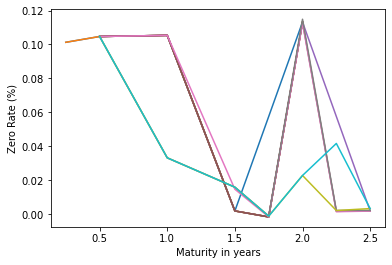

In [10]:
y = []
x=[]

for i,j in top10.iterrows():
    yield_curve.add_instrument(100, coupons10[i], 0., last_price[i])
    yield_curve.add_instrument(100, coupons10[i], ttm10[i], last_price[i], 2)
    
    
    y.append(yield_curve.get_zero_rates())
    x.append(yield_curve.get_maturities())
    
    2* x[i]
    plt.plot(x[i],y[i])
    plt.ylabel('Zero Rate (%)')
    plt.xlabel('Maturity in years')

    
spot_maturity = pd.DataFrame(y, columns = x[0])
spot_maturity = spot_maturity.fillna(0)
spot_maturity = spot_maturity.iloc[:, :-1]
#spot_maturity = spot_maturity.iloc[:, : 1]
spot_maturity

In [11]:
class ForwardRates(object):
    # Class to calculate the forward rate  between 2 different time period
    # inputs are the spot rate for those 2 time period, and the 2 time periods
    def __init__(self):
        self.forward_rates = []
        self.spot_rates = dict()

        
    def add_spot_rate(self, T, spot_rate): 
        self.spot_rates[T] = spot_rate

        # calculate forward rate for any 2 time period
    def __calculate_forward_rate___(self, T1, T2): 
        R1 = self.spot_rates[T1]
        R2 = self.spot_rates[T2]
        forward_rate = (R2*T2 - R1*T1)/(T2 - T1) 
        return forward_rate
    
    # get all forward rates for all subset [T1,T2] of T
    def get_forward_rates(self):

        periods = sorted(self.spot_rates.keys()) 
        for T2, T1 in zip(periods, periods[1:]):
            forward_rate = self.__calculate_forward_rate___(T1, T2)
            self.forward_rates.append(forward_rate) 
        return self.forward_rates

In [12]:
fr = ForwardRates()

In [13]:

fr.add_spot_rate(0.25, 10.127)
fr.add_spot_rate(0.50, 10.469)
fr.add_spot_rate(1.00, 10.536)
fr.add_spot_rate(1.50, 10.681)
fr.add_spot_rate(2.00, 10.808)
print(fr.get_forward_rates())

[10.810999999999998, 10.603, 10.971, 11.189]


In [14]:
for i, j in spot_maturity.iterrows():
    fr.add_spot_rate( i, j )
    print(fr.get_forward_rates())
    
    #for item in j.index:
        #print(item)
        
        #fr.add_spot_rate(item, j)
       # z.append(fr.get_forward_rates())
        #print(z[i])
        
#plt.plot(z)
                     




NameError: name 'spot_maturity' is not defined

In [15]:
for i in spot_maturity.columns:
    #print( 2*i)
    
    for item in spot_maturity[i]:
        #print(i,item)
        fr.add_spot_rate(i,100*item)
        print(fr.get_forward_rates())

NameError: name 'spot_maturity' is not defined

In [16]:
def bond_ytm(price, par, T, coup, freq=2, guess=0.005):
    freq = float(freq)
    periods = T*freq
    coupon = coup/2
    dt = [(i+1)/freq for i in range(int(periods))]
    #solve for yield to maturity
    ytm_func = lambda y: sum([coupon/pow((1+y/2),(freq*t))  +  par/pow((1+y/freq),(freq*t)) for t in dt]) - price
    return optimize.newton(ytm_func, guess)


ytm = bond_ytm(95.0428, 100, 1.5, 5.75, 2)
ytm

In [17]:
ytm = bond_ytm(95.0428, 100, 1.5, 5.75, 2)
print(ytm)
clean_price_data

1.864811012508044


,0,1,2,3,4,5,6,7,8,9
1/18/2021,103.150,103.290,100.130,118.245,107.425,108.140,105.560,102.955,109.97,108.140
1/19/2021,103.140,103.280,100.125,118.220,107.410,108.140,105.565,102.960,110.06,108.140
1/20/2021,103.100,103.250,100.095,118.165,107.400,108.150,105.530,102.930,109.94,108.150
1/21/2021,103.085,103.235,100.095,118.095,107.365,108.040,105.365,102.715,109.65,108.040
1/22/2021,103.090,103.245,100.100,118.085,107.350,108.065,105.385,102.780,109.70,108.065
1/25/2021,103.060,103.215,100.075,118.030,107.350,108.155,105.495,102.965,110.03,108.155
1/26/2021,103.065,103.225,100.095,118.025,107.380,108.135,105.470,102.895,109.92,108.135
1/27/2021,103.095,103.250,100.125,118.040,107.415,108.210,105.550,103.025,110.07,108.210
1/28/2021,103.095,103.245,100.125,117.980,107.395,108.140,105.490,102.935,109.91,108.140
1/29/2021,103.075,103.245,100.125,117.940,107.355,108.095,105.415,102.825,109.82,108.095


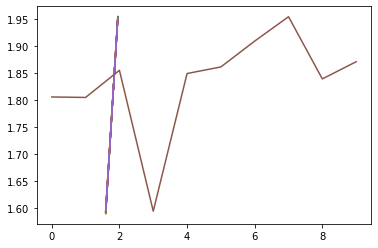

In [29]:
#Get bond yield for each trading day from Jan 18th to Feb 2nd 

w = []
a = []
b = []
c = []
d = []
e = []
f = []
g = []
l = []
m = []
n = []
for item in range(len(last_price)):
    #print(bond_ytm(last_price[item], 100, ttm10[item], coupons10[item], 2))
    a.append((bond_ytm(last_price[item], 100, ttm10[item], coupons10[item], 2)))
    b.append((bond_ytm(first_price[item], 100, ttm10[item], coupons10[item], 2)))
    c.append((bond_ytm(second_price[item], 100, ttm10[item], coupons10[item], 2)))
    d.append((bond_ytm(third_price[item], 100, ttm10[item], coupons10[item], 2)))
    e.append((bond_ytm(fourth_price[item], 100, ttm10[item], coupons10[item], 2)))
    f.append((bond_ytm(fifth_price[item], 100, ttm10[item], coupons10[item], 2)))
    g.append((bond_ytm(sixth_price[item], 100, ttm10[item], coupons10[item], 2)))
    l.append((bond_ytm(seventh_price[item], 100, ttm10[item], coupons10[item], 2)))
    m.append((bond_ytm(eigth_price[item], 100, ttm10[item], coupons10[item], 2)))
    n.append((bond_ytm(ninth_price[item], 100, ttm10[item], coupons10[item], 2)))
    w.append((bond_ytm(tenth_price[item], 100, ttm10[item], coupons10[item], 2)))

plt.plot(a, b, c, d, e, f, g, l, m, n, w)
#plt.plot(c[item])
#plt.plot(b)

In [19]:
def bond_price(par, T, ytm, coup, freq=2):
    freq = float(freq)
    periods = T*freq
    coupon = coup/100.*par/freq
    dt = [(i+1)/freq for i in range(int(periods))]
    price = sum([coupon/pow((1+ytm/freq),(freq*t)) for t in dt]) + \
               par/pow((1+ytm/freq),(freq*T))
    return price

In [20]:
bond_price(100, 1.5, w[0], 5.75, 2)

17.234988125899488

In [21]:
#Calculate the bond price from each days ytm

list1 = []
list2 = []
list3 = []
list4 = []
list5 = []
list6 = []
list7 = []
list8 = []
list9 = []
list10 = []
for item in range(len(last_price)):
    list1.append(bond_price(last_price[item], ttm10[item], w[item], coupons10[item], 2))
    list2.append((bond_price(first_price[item], ttm10[item], a[item], coupons10[item], 2)))
    list3.append((bond_price(second_price[item], ttm10[item], c[item], coupons10[item], 2)))
    list4.append((bond_price(third_price[item], ttm10[item], c[item], coupons10[item], 2)))
    list5.append((bond_price(fourth_price[item], ttm10[item], c[item], coupons10[item], 2)))

    list6.append((bond_price(fifth_price[item], ttm10[item], c[item], coupons10[item], 2)))

    list7.append((bond_price(sixth_price[item], ttm10[item], c[item], coupons10[item], 2)))

    list8.append((bond_price(seventh_price[item], ttm10[item], c[item], coupons10[item], 2)))

    list9.append((bond_price(eigth_price[item], ttm10[item], c[item], coupons10[item], 2)))

    list10.append((bond_price(ninth_price[item], ttm10[item], c[item], coupons10[item], 2)))

bond_values = pd.DataFrame([list1, list2, list3, list4, list5, list6, list7, list8, list9, list10])


#plt.plot([list1, list2, list3, list4, list5, list6, list7, list8, list9, list10])
    
bond_values

,0,1,2,3,4,5,6,7,8,9
0,5.731071,7.806200,7.119413,12.750920,2.711436,1.634712,0.902907,0.542631,1.201281,1.301725
1,5.736036,7.810516,7.121127,12.783894,2.713645,1.635650,0.904319,0.543373,1.202937,1.302269
2,5.742913,7.813933,7.118346,12.839434,2.715452,1.636158,0.905470,0.543828,1.206189,1.302512
3,5.740686,7.811663,7.116213,12.833460,2.715199,1.636310,0.905170,0.543670,1.204874,1.302633
4,5.739850,7.810529,7.116213,12.825858,2.714314,1.634645,0.903754,0.542534,1.201696,1.301308
5,5.740129,7.811285,7.116569,12.824772,2.713935,1.635023,0.903926,0.542878,1.202244,1.301609
6,5.738458,7.809015,7.114792,12.818798,2.713935,1.636385,0.904869,0.543855,1.205860,1.302693
7,5.738737,7.809772,7.116213,12.818255,2.714693,1.636083,0.904655,0.543485,1.204655,1.302452
8,5.740407,7.811663,7.118346,12.819885,2.715578,1.637217,0.905341,0.544172,1.206299,1.303356
9,5.740407,7.811285,7.118346,12.813368,2.715072,1.636158,0.904827,0.543696,1.204545,1.302512


,0,1,2,3,4,5,6,7,8,9
0,0.160832,0.120538,0.131433,0.075502,0.313940,0.477307,0.745518,1.044815,0.605651,0.569969
1,0.160703,0.120475,0.131403,0.075315,0.313721,0.477090,0.744698,1.043930,0.605025,0.569787
2,0.160525,0.120425,0.131451,0.075001,0.313542,0.476972,0.744030,1.043387,0.603801,0.569706
3,0.160583,0.120458,0.131488,0.075034,0.313567,0.476937,0.744204,1.043576,0.604295,0.569666
4,0.160605,0.120475,0.131488,0.075077,0.313655,0.477323,0.745026,1.044931,0.605494,0.570108
5,0.160597,0.120464,0.131482,0.075083,0.313692,0.477235,0.744926,1.044521,0.605287,0.570007
6,0.160641,0.120497,0.131513,0.075117,0.313692,0.476919,0.744378,1.043355,0.603924,0.569646
7,0.160633,0.120486,0.131488,0.075120,0.313617,0.476989,0.744503,1.043796,0.604378,0.569726
8,0.160590,0.120458,0.131451,0.075111,0.313529,0.476726,0.744104,1.042978,0.603760,0.569425
9,0.160590,0.120464,0.131451,0.075148,0.313580,0.476972,0.744403,1.043544,0.604419,0.569706


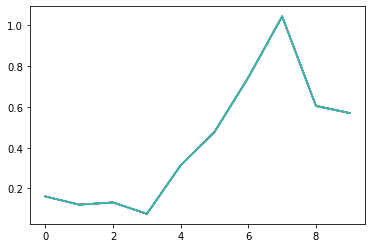

In [22]:
x = []
for i, j in bond_values.iterrows():
    rij1 = (j)
    rij = (j+1)
    x.append( np.log(rij/rij1))
    plt.plot(np.log(rij/rij1))
log_returns = pd.DataFrame(x)
log_returns

In [34]:
cov = pd.DataFrame()
cov = log_returns.cov
cov


<bound method DataFrame.cov of           0         1         2         3         4         5         6  \
0  0.160832  0.120538  0.131433  0.075502  0.313940  0.477307  0.745518   
1  0.160703  0.120475  0.131403  0.075315  0.313721  0.477090  0.744698   
2  0.160525  0.120425  0.131451  0.075001  0.313542  0.476972  0.744030   
3  0.160583  0.120458  0.131488  0.075034  0.313567  0.476937  0.744204   
4  0.160605  0.120475  0.131488  0.075077  0.313655  0.477323  0.745026   
5  0.160597  0.120464  0.131482  0.075083  0.313692  0.477235  0.744926   
6  0.160641  0.120497  0.131513  0.075117  0.313692  0.476919  0.744378   
7  0.160633  0.120486  0.131488  0.075120  0.313617  0.476989  0.744503   
8  0.160590  0.120458  0.131451  0.075111  0.313529  0.476726  0.744104   
9  0.160590  0.120464  0.131451  0.075148  0.313580  0.476972  0.744403   

          7         8         9  
0  1.044815  0.605651  0.569969  
1  1.043930  0.605025  0.569787  
2  1.043387  0.603801  0.569706  
3  1.04

AttributeError: 'function' object has no attribute 'apply'